In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
#!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WAnGFkeK7v54QLSP6MbE12N0d58cEPJE' -O drive/colab_notebook/lstm.zip

In [0]:
!unzip drive/colab_notebook/lstm.zip -d drive/colab_notebook/

# Introduction

### About the dataset and the problem:

This Dataset is from PHM 2018 data challenge: https://www.phmsociety.org/events/conference/phm/18/data-challenge

The objective in the challenge is to identify equipment faults and predict Remaining Useful Life (RUL) before the next fault occurs

The equipment at hand is Ion Etching Machines. The data set consists of 20 Ion Etching machines sensor data along with time of faults, there are over 1500 fault events

For this notebook the dataset was reduced, after significant data engineering, to about 30% of normal operation, all fault data for 5 sensors

This Notebook will demonstrate using LSTM sequence to sequence model for solving fault detection. The same method can be used to generate a RUL estimator which is outside of the scope of this notebook

We will be using Keras with Tensorflow backend to build the LSTM for sequence to sequence

# Gentle refresher on LSTM

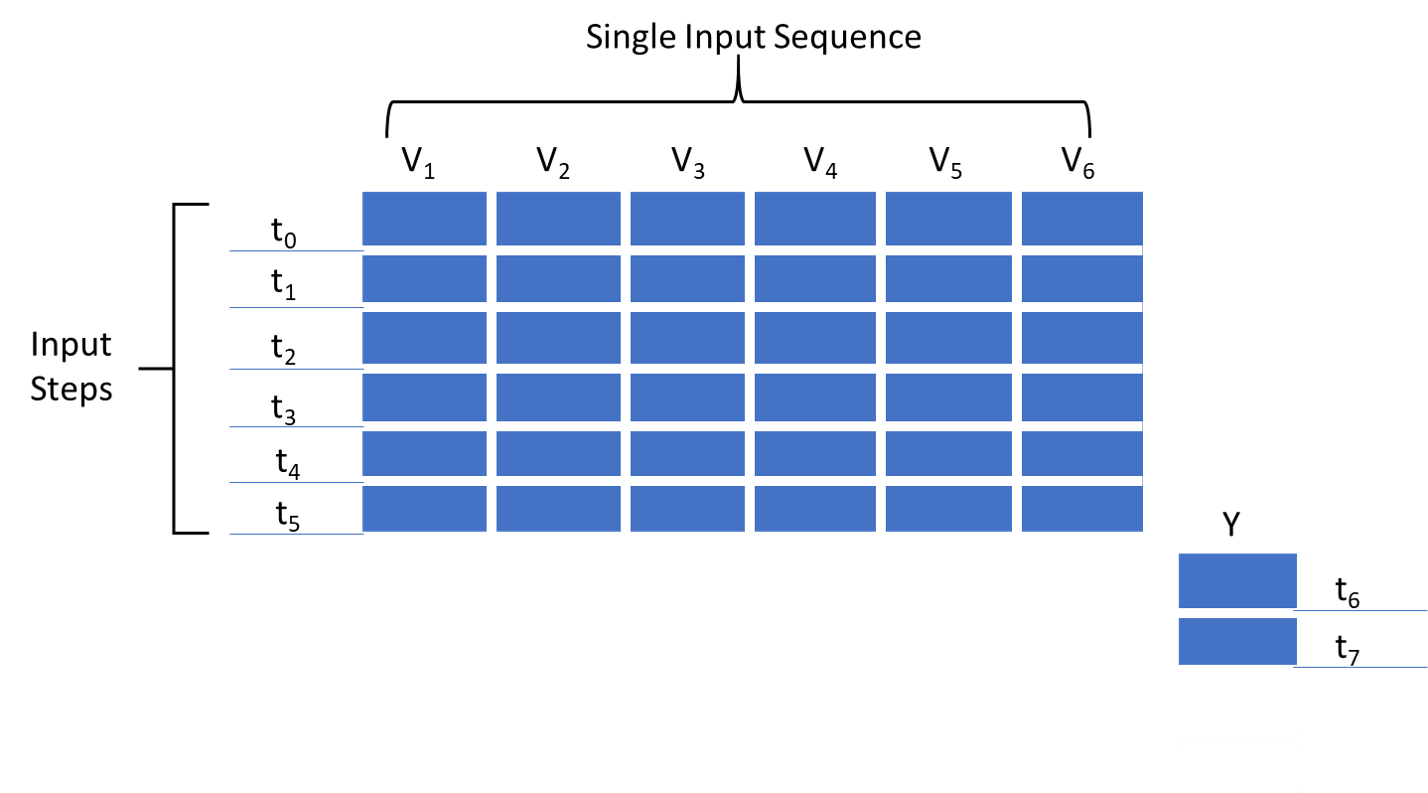

In [147]:
from IPython.display import Image
Image('drive/colab_notebook/images/timesequence.png')

**Building a vanilla LSTM network**
```python
model = Sequential()
'''The input to an LSTM layer has to be 3D tensor. The default LSTM layer output is 2D '''
model.add(LSTM(32, input_shape=(NUM_TIMESTEPS,features )))## The shape of each input sample is defined in 1st layer only
model.add(Dense(output))
```

** How do we stack layers: It's all about managing input and output from one layer to another**

```python
model = Sequential()
'''
Input to LSTM layer has to always be 3D, since the output is by default is 2D. We need to make 
return_sequences=True in order to stack a second LSTM layer. 
This will make the output of the 1st LSTM layer return a 3D output, which can now be input to the 2nd LSTM layer
dropout and Recurrent_dropout helps with regularizing the network and reduce overfitting. 
'''
model.add(LSTM(32, input_shape=(NUM_TIMESTEPS,features ),dropout=0.3, recurrent_dropout=0.5,return_sequences=True))
model.add(LSTM(64, input_shape=(NUM_TIMESTEPS,features ),dropout=0.3, recurrent_dropout=0.5))
model.add(Dense(output))
```

For this particular problem we will use sequence to sequence LSTM network, the method will work in the following way:

- Train a seq2seq network on Normal data (this is we're pnly using the 1st 30% of normal data)
- This seq2seq will act as an autoencoder, the network will regenerate the input sequence
- We use this network to regenerate the input sequence and create a re-construction error
- We then Train a Random Forrest on the reconstruction error to classify Faulty and normal sequences

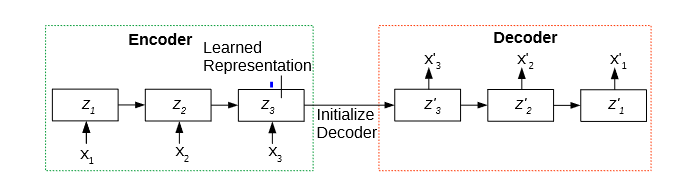

In [148]:
Image('drive/colab_notebook/images/seq2seq.png')

In [0]:
'''
General libraries
'''
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import itertools

'''
Scikit Learn
'''

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,mean_squared_error
from sklearn.model_selection import *
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

'''
Keras
'''

import keras
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Input, TimeDistributed, Masking,RepeatVector
from keras.models import Model, Sequential,load_model
from keras.optimizers import RMSprop
from keras import layers
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf;

### Data Preparation for sequence modeling

1. Loading lists of arrays corresponding for each operation on the ion etching machines
2. apply standard scaling
3. create tensors from lists using Keras sequence function

# New Section

In [0]:
def get_data(folder='drive/colab_notebook/'):
    filenames=['train.pkl','val.pkl','test.pkl','fault.pkl']
    dataset=[pickle.load(open(folder+file,'rb')) for file in filenames]
    return dataset[0],dataset[1],dataset[2],dataset[3]

In [0]:
train, val, test, train_flt=get_data()

**Preparing training data to apply standard scaling**

In [0]:
train_scale=np.vstack(train)

** Fitting standard scaler to training and applying it to the datasets**

In [201]:
scalerx=StandardScaler()
scalerx.fit(train_scale)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
train_norm=[scalerx.transform(train[seq]) for seq in range(len(train))]
val_norm=[scalerx.transform(val[seq]) for seq in range(len(val))]
test_norm=[scalerx.transform(test[seq]) for seq in range(len(test))]

In [0]:
train_flt_norm=[scalerx.transform(train_flt[seq]) for seq in range(len(train_flt))]

** Setting sequence length to 150, this was arrived to emperically through trial and error**

In [0]:
seq_len=150

** Transforming lists into sequences**

In [0]:
'''
pad_sequences function is a very versatile function. it allows us to handle cases 
of uneven sequence length by padding or truncating to a specificed length.
Default pad value is 0, but user can apply any number or pass an impute into it

'''
train_X_norm=sequence.pad_sequences(train_norm, dtype='float32', maxlen=seq_len, padding='post',truncating='post')
val_X_norm=sequence.pad_sequences(val_norm, dtype='float32', maxlen=seq_len, padding='post',truncating='post')
test_X_norm=sequence.pad_sequences(test_norm, dtype='float32', maxlen=seq_len, padding='post',truncating='post')
train_flt_nseq=sequence.pad_sequences(train_flt_norm, dtype='float32', maxlen=seq_len, padding='post',truncating='post')

In [0]:
'''
We want our LSTM network to regenerate the input sequence. 
Therefore the Target sequence is the same as input sequence. Y=X 

'''

train_Y = train_X_norm
val_Y=val_X_norm
test_Y=test_X_norm

In [0]:
output=train_Y.shape[-1]

In [208]:
output

5

In [0]:
seqlen_train=len(train_X_norm)
seqlen_val=len(val_X_norm)
seqlen_test=len(test_X_norm)

In [210]:
'''WE got our Tensors'''
print('train X and Y',train_X_norm.shape,train_Y.shape)

train X and Y (11264, 150, 5) (11264, 150, 5)


In [211]:
print('val X and Y',val_X_norm.shape,val_Y.shape)

val X and Y (2817, 150, 5) (2817, 150, 5)


In [212]:
print('test X and Y',test_X_norm.shape,test_Y.shape)

test X and Y (1565, 150, 5) (1565, 150, 5)


In [0]:
K.clear_session()

In [142]:
model = Sequential()
'''The input to an LSTM layer has to be 3D tensor. The default LSTM layer output is 2D '''
model.add(LSTM(200, input_shape=(train_X_norm.shape[-2],train_X_norm.shape[-1]),implementation=2))
'''
The repeatvector method reconstructs the output of the LSTM into 3D 
the combination of the 1st LSTM layer and repeat vector make up the encoder
'''
model.add(RepeatVector(train_X_norm.shape[-2])) 
'''The 2nd LSTM layer along with the timedistributed output make up the decoder '''
model.add(LSTM(200,implementation=2,return_sequences=True))
model.add(TimeDistributed(Dense(output)))
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 200)               164800    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 150, 200)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 200)          320800    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 150, 5)            1005      
Total params: 486,605
Trainable params: 486,605
Non-trainable params: 0
_________________________________________________________________


In [0]:
es=[EarlyStopping(monitor='val_loss',patience=20)]

In [0]:
'''
you can test with 10 epochs to make sure code works 
'''
history=model.fit(train_X_norm, train_Y, batch_size=256,shuffle=True,epochs=300,validation_data=(val_X_norm,val_Y),callbacks=es)

Train on 11264 samples, validate on 2817 samples
Epoch 1/300
11264/11264 [==============================] - 14s 1ms/step - loss: 0.6081 - val_loss: 0.3923
Epoch 2/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.3576 - val_loss: 0.3013
Epoch 3/300
11264/11264 [==============================] - 14s 1ms/step - loss: 0.2493 - val_loss: 0.1897
Epoch 4/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1955 - val_loss: 0.1542
Epoch 5/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1597 - val_loss: 0.1388
Epoch 6/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1407 - val_loss: 0.1458
Epoch 7/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1299 - val_loss: 0.1031
Epoch 8/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1159 - val_loss: 0.1025
Epoch 9/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.1135 - val_loss: 0.08

11264/11264 [==============================] - 13s 1ms/step - loss: 0.0214 - val_loss: 0.0210
Epoch 154/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0222 - val_loss: 0.0166
Epoch 155/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0220 - val_loss: 0.0186
Epoch 156/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0230 - val_loss: 0.0184
Epoch 157/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0219 - val_loss: 0.0171
Epoch 158/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0206 - val_loss: 0.0197
Epoch 159/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0201 - val_loss: 0.0185
Epoch 160/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0318 - val_loss: 0.0427
Epoch 161/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0265 - val_loss: 0.0198
Epoch 162/300
11264/11264 [===============

Epoch 229/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0168 - val_loss: 0.0106
Epoch 230/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0147 - val_loss: 0.0126
Epoch 231/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0174 - val_loss: 0.0123
Epoch 232/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 233/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0161 - val_loss: 0.0159
Epoch 234/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0184 - val_loss: 0.0168
Epoch 235/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0165 - val_loss: 0.0176
Epoch 236/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0193 - val_loss: 0.0137
Epoch 237/300
11264/11264 [==============================] - 13s 1ms/step - loss: 0.0156 - val_loss: 0.0105
Epoch 238/300
11264/11264 [=

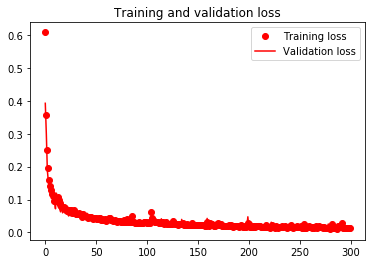

In [0]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_loss))

plt.figure()

plt.plot(epochs, train_loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show();

In [213]:
model=load_model('drive/colab_notebook/seq2seq150seq.h5')

/usr/local/lib/python3.6/dist-packages/keras/models.py:318: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [0]:
pred_train=model.predict(train_X_norm)

In [215]:
pred_train.shape

(11264, 150, 5)

** Reconstruction of the input sequence on training sample shows low reconstruction error**

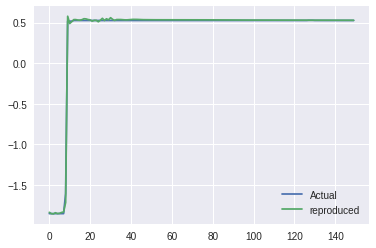

In [216]:
plt.plot(train_Y[5][:,3],label="Actual")
plt.plot(pred_train[5][:,3],label="reproduced")
plt.legend()
plt.show();

In [0]:
pred_val=model.predict(val_X_norm)

** Reconstruction of the input sequence on Validation and test samples show low reconstruction error**

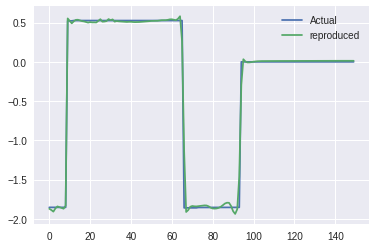

In [218]:
plt.plot(val_Y[5][:,3],label="Actual")
plt.plot(pred_val[5][:,3],label="reproduced")
plt.legend()
plt.show();

In [0]:
pred_test=model.predict(test_X_norm)

In [220]:
pred_test.shape

(1565, 150, 5)

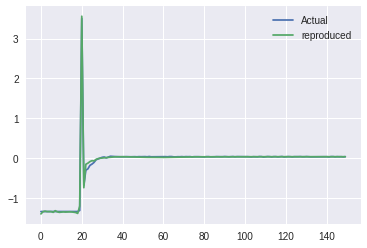

In [221]:
plt.plot(test_Y[190][:,1],label="Actual")
plt.plot(pred_test[190][:,1],label="reproduced")
plt.legend()
plt.show();

In [0]:
pred_flt=model.predict(train_flt_nseq)

** How does reconstruction error look on faulty data?**

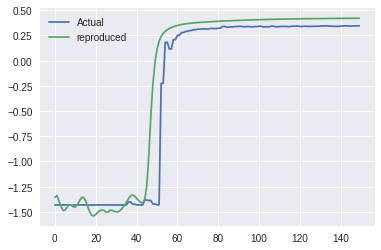

In [223]:
plt.plot(train_flt_nseq[1000][:,2],label="Actual")
plt.plot(pred_flt[1000][:,2],label="reproduced")
plt.legend()
plt.show();

In [0]:
train_error=[mean_squared_error(train_Y[i],pred_train[i]) for i in range(len(train_Y))]

In [0]:
test_error=[mean_squared_error(test_Y[i],pred_test[i]) for i in range(len(test_Y))]

In [0]:
flt_error=[mean_squared_error(train_flt_nseq[i],pred_flt[i]) for i in range(len(pred_flt))]

** Overall reconstruction error on faulty data is 10x higher than reconstruction of normal data** 

In [227]:
print(np.mean(np.asarray(train_error)),np.mean(np.asarray(test_error)), np.mean(np.asarray(flt_error)))

0.01054386 0.006947308 0.08848256


### Building a classifier on reconstruction error

1. We will generate one row per sequence, where each row has min, max, mean, kurtosis, and variance of each sensor reconstruction error
2. This will give us a data set of n rows of normal reconstruction errors statistics, and m rows of faulty reconstruction errors
3. We will train a random forest on this data to identify faults

In [0]:
'''
concatenating all normal datasets into a single array
'''
norm_arr=np.vstack((train_X_norm,val_X_norm,test_X_norm))

In [0]:
'''
concatenating all predictions on normal datasets into a single array
'''
norm_pred_arr=np.vstack((pred_train,pred_val,pred_test))

In [0]:
'''
creating residual array for normal data 
'''
norm_resid_arr=norm_arr-norm_pred_arr

In [0]:
'''
creating residual array for faulty data 
'''
flt_resid_arr=train_flt_nseq-pred_flt

In [0]:
def create_dist(arr_list):
    
    '''
    this function takes as input a list of arrays or a 3D tensor (NxMxF)
    it applies scipy stats function to each list of arrays 
    Returns a 2 D array (NxW)
    '''
    
    norm_dist=[stats.describe(arr_list[i]) for i in range(len(arr_list))]
    
    normdistarrlist=[np.hstack(np.asarray((norm_dist[i].minmax[0],norm_dist[i].minmax[1],norm_dist[i].mean,norm_dist[i].variance,
                               norm_dist[i].kurtosis))) for i in range(len(norm_dist))]
    
    return np.vstack(normdistarrlist)

In [0]:
normdistarr=create_dist(norm_resid_arr)

In [234]:
normdistarr.shape

(15646, 25)

** Repeating the process above for the faulty data**

In [0]:
fltdistarr=create_dist(flt_resid_arr)

In [236]:
fltdistarr.shape

(1950, 25)

In [0]:
'''
add fault=0 to to normal data 
'''
norm_resid=np.hstack((normdistarr,np.zeros((normdistarr.shape[0],1))))

In [0]:
'''
add fault=1 to to normal data 
'''
flt_resid=np.hstack((fltdistarr,np.ones((fltdistarr.shape[0],1))))

In [0]:
resid_all=np.vstack((norm_resid,flt_resid))

In [240]:
resid_all.shape

(17596, 26)

In [0]:
'''
stacking up all residual statistics into a dataframe 
'''
dfX=pd.DataFrame(resid_all[:,:-1]).join(pd.DataFrame(resid_all[:,-1],columns=['fault']))

In [0]:
def split_data(data_df,category,nsplit,testsize,random=2301):
    trainsplit  =  StratifiedShuffleSplit ( n_splits = nsplit ,  test_size = testsize ,  random_state = random )
    
    """
    n_splits is for number of splits
    test_size is % size from the entire population(between 0 and 1) for the test data set
    random_state this is used to generate repeatable results next time we run this code again
    """
    for  train_index ,  test_index  in  trainsplit . split ( data_df ,  data_df[category]):
        strat_train_set  =  data_df.loc [train_index ]
        strat_test_set  =  data_df.loc[test_index ]
        
    """ 
    stratifying by classification variables
        
    """
    return strat_train_set,strat_test_set

In [0]:
train_df,test_df =split_data(data_df=dfX,category=["fault"],nsplit=1,testsize=0.1)

X_train=train_df.iloc[:,:-1].values

X_test=test_df.iloc[:,:-1].values
y_train=train_df["fault"].values
y_test=test_df["fault"].values;

In [0]:
'''
- Setting hyperparameters for Random Forest, adjust number of trees range between 100 and 1000 
Call the Random Forest Classifier, seed=2301
- use CV=5 to 10 for GridSearch
'''
# Enter your code here ~3 lines
params={'n_estimators':[100,500,1000],'max_depth': [3,100,1000],'min_samples_split':[2,10]}
ranf_clf=RandomForestClassifier(random_state=2301,n_jobs=-1)
gs_ranf_clf=GridSearchCV(estimator=ranf_clf,param_grid=params,cv=5,return_train_score=False)

In [0]:
'''
- We will now fit the model and predict the training data set
'''
# Enter your code here ~ 2 line
gs_ranf_clf=gs_ranf_clf.fit(X_train, y_train)

** The results below show slightly overfit model on the training data**
- Accuracy value is for Validation, while confusion matrix is on training

In [246]:
joblib.dump(gs_ranf_clf,'drive/colab_notebook/ranfresid150.pkl')

['drive/colab_notebook/ranfresid150.pkl']

In [0]:
gs_ranf_clf=joblib.load('drive/colab_notebook/ranfresid150.pkl')

In [248]:
train_pred_ranf=gs_ranf_clf.predict(X_train)
#code ends here

ranfcv_acc=gs_ranf_clf.best_score_
confusion = confusion_matrix(y_train, train_pred_ranf)
print("accuracy:\n{}".format(ranfcv_acc))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.9701944935589796
Confusion matrix:
[[14081     0]
 [    0  1755]]


In [0]:
pred_test=gs_ranf_clf.predict(X_test)

In [251]:
acc_test=accuracy_score(y_test, pred_test)
confusion = confusion_matrix(y_test, pred_test)
print("accuracy:\n{}".format(acc_test))
print("Confusion matrix:\n{}".format(confusion))

accuracy:
0.9738636363636364
Confusion matrix:
[[1552   13]
 [  33  162]]


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[0.99169329 0.00830671]
 [0.16923077 0.83076923]]


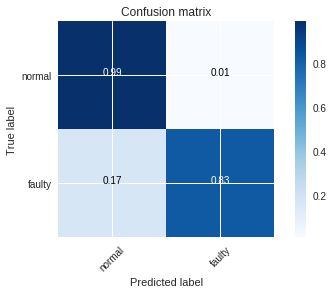

In [253]:
plot_confusion_matrix(confusion,classes=['normal','faulty'],normalize=True)